# Evaluating Distributions and generating Experimental Crosstabs for the Evaluation of Experiments as well as Experimental Comparisons with T-Tests, Purpose Assumptions, Corrections and Implementations in Python

## The purpose of the T-test is to compare if there are mean differences between two groups of interest. When we are interested in comparing statistical differences between more than two groups, and we conduct multiple t-tests, we will end up increasing the likelihood of a false positive (type I error) where we are incorrectly rejecting the null hypothesis that there are no statistical differences between groups. One way to address this is to use the Bonferroni correction. The Bonferroni correction, the namesake of Carlo Emilio Bonferroni, accounts for what we lose in a p-hacking quest in the experimentation, which is the justification for taking p-values at face value. By intuition, when we go searching for significant differences everywhere, the chance of seeing an apparent significant difference by chance anywhere increases. Using the Bonferroni correction, if the starting alpha/significance level is .05 and we are testing 10 hypotheses, then the corrected alpha/significance level we should use would be .005. Understanding the lack of an incentive to make such an adjustment is straightforward. Another way to address this is to first use ANOVA to detect statistical differences between all groups before deciding whether to use t tests to look for pairwise comparisons between groups.

## T test comparisons uses the means, counts and standard deviations of a treatment and control in comparison to an idealized normal distribution to calculate a p value, which by intuition is the likelihood of seeing a mean difference of the same or more extreme magnitude between treatment and control as a result of chance. This is done through a comparison to an idealized normal distribution, through the calculation of a t-statistic. While the test statistic is assumed to follow an idealized normal distribution if  the scaling term, but where the scaling term is unknown and it is instead estimated based on the data, which is assumed to follow the student's t distribution.This process can be thought of trying to disentangle the signal (mean difference and counts) from the noise variability. Here the mean difference is the direction of the signal and the counts are the strength of the signal.

In [1]:
import numpy as np
import dask.array as da
import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import pandas as pd
import seaborn as sns

import numpy as np
import pandas as pd
from statsmodels.stats.power import NormalIndPower, TTestIndPower
from scipy.stats import ttest_ind_from_stats
import numpy as np
import scipy


/home/gao/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('df_panel_fix.csv')

In [3]:
df_subset = df[["year", "reg", "province", "gdp", "fdi", 'it',"specific"]]
df_subset.columns = ["year", "region", "province", "gdp", "fdi", 'it',"specific"]

In [4]:
df=df_subset
df

,year,region,province,gdp,fdi,it,specific
0,1996,East China,Anhui,2093.30,50661,631930,147002.0
1,1997,East China,Anhui,2347.32,43443,657860,151981.0
2,1998,East China,Anhui,2542.96,27673,889463,174930.0
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0
...,...,...,...,...,...,...,...
355,2003,East China,Zhejiang,9705.02,498055,2261631,391292.0
356,2004,East China,Zhejiang,11648.70,668128,3162299,656175.0
357,2005,East China,Zhejiang,13417.68,772000,2370200,656175.0
358,2006,East China,Zhejiang,15718.47,888935,2553268,1017303.0


East China
gdp
East China
fdi
East China
it
North China
gdp
North China
fdi
North China
it


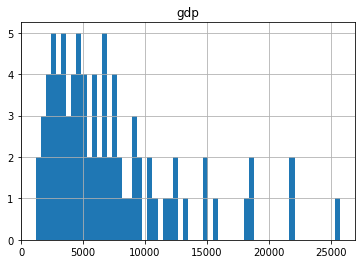

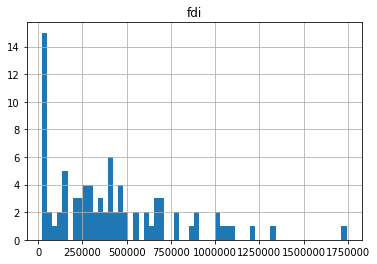

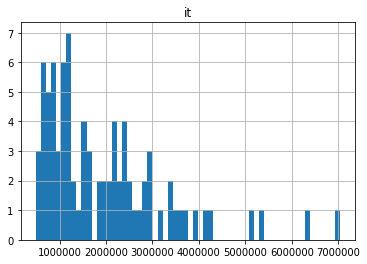

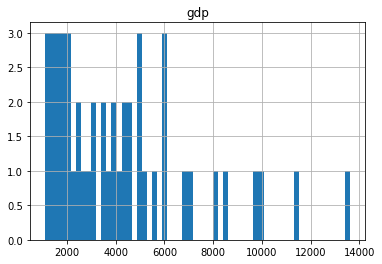

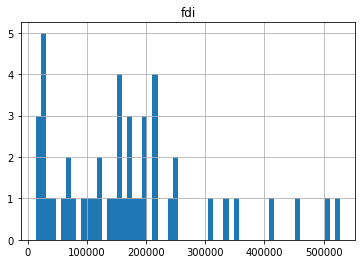

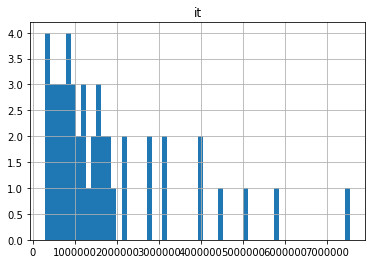

In [5]:
# Add distributions by region
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(nrows=3, ncols=3)

test_cells = ['East China', 'North China']
metrics = ['gdp', 'fdi', 'it']

for test_cell in test_cells:
    for metric in metrics:
        df.loc[df["region"] == test_cell].hist(column=[metric], bins=60)
        print(test_cell)
        print(metric)

        

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7ec7cbdd8>]],
      dtype=object)

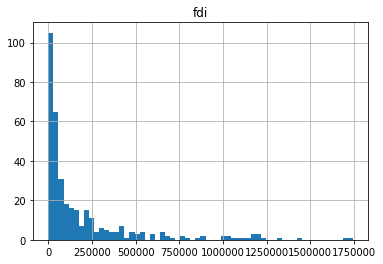

In [6]:
df.hist(column=['fdi'], bins=60)

## Distributions of Dependant Variables

### Right skew

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7ec6e00f0>]],
      dtype=object)

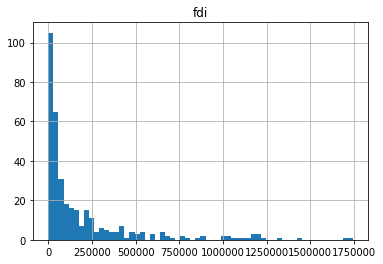

In [7]:
df.hist(column=['fdi'], bins=60)

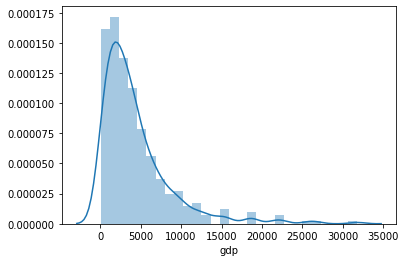

In [8]:
sns.distplot(df['gdp'])

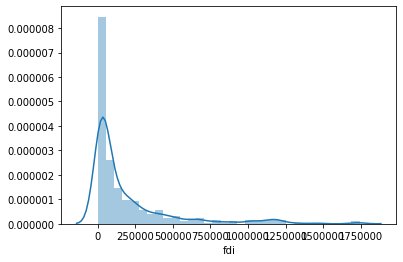

In [9]:
sns.distplot(df['fdi'])

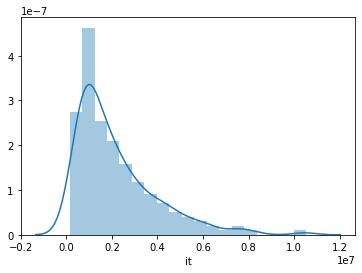

In [10]:
sns.distplot(df['it'])

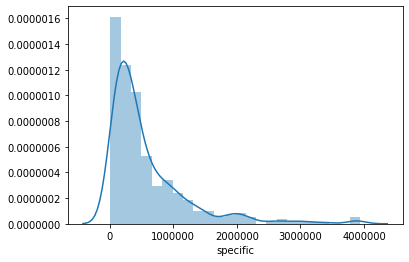

In [11]:
sns.distplot(df['specific'].dropna())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7ec31ccc0>]],
      dtype=object)

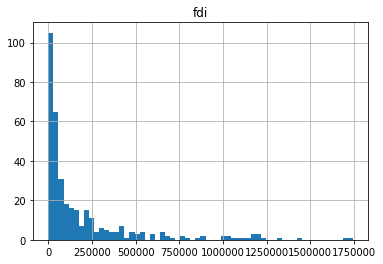

In [12]:
df.hist(column=['fdi'], bins=60)

## Removal of GDP value outliers more than 3 standard deviations away from the mean

## outlier removal of rows with GDP values that are > 3 standard deviations away form the mean

In [13]:
import scipy.stats as stats

In [14]:
df['gdp_zscore'] = stats.zscore(df['gdp'])

## these are the observations more then > 3 SDs away from the mean of gdp that will be dropped

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7ec873208>]],
      dtype=object)

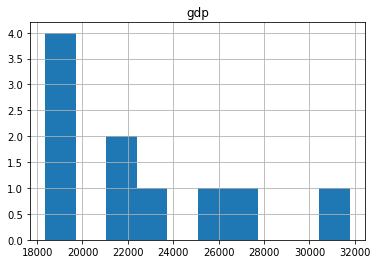

In [15]:
df[abs(df['gdp_zscore'])>3].hist(column = ['gdp'])

In [16]:
df_no_gdp_outliers=df[abs(df['gdp_zscore'])<3]

In [17]:
df_no_gdp_outliers

,year,region,province,gdp,fdi,it,specific,gdp_zscore
0,1996,East China,Anhui,2093.30,50661,631930,147002.0,-0.521466
1,1997,East China,Anhui,2347.32,43443,657860,151981.0,-0.464746
2,1998,East China,Anhui,2542.96,27673,889463,174930.0,-0.421061
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0,-0.383239
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0,-0.340870
...,...,...,...,...,...,...,...,...
354,2002,East China,Zhejiang,8003.67,307610,1962633,365437.0,0.798274
355,2003,East China,Zhejiang,9705.02,498055,2261631,391292.0,1.178172
356,2004,East China,Zhejiang,11648.70,668128,3162299,656175.0,1.612181
357,2005,East China,Zhejiang,13417.68,772000,2370200,656175.0,2.007180


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7ec95e4e0>]],
      dtype=object)

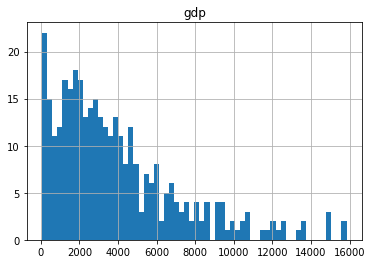

In [18]:
df_no_gdp_outliers.hist(column=['gdp'], bins=60)

In [19]:
counts_fiscal=df.groupby('region').count()
counts_fiscal

,year,province,gdp,fdi,it,specific,gdp_zscore
region,,,,,,,
East China,84,84,84,84,84,84,84
North China,48,48,48,48,48,47,48
Northeast China,36,36,36,36,36,36,36
Northwest China,60,60,60,60,60,60,60
South Central China,72,72,72,72,72,72,72
Southwest China,60,60,60,60,60,57,60


In [20]:
counts_fiscal=df.groupby('province').count()
counts_fiscal

,year,region,gdp,fdi,it,specific,gdp_zscore
province,,,,,,,
Anhui,12,12,12,12,12,12,12
Beijing,12,12,12,12,12,12,12
Chongqing,12,12,12,12,12,9,12
Fujian,12,12,12,12,12,12,12
Gansu,12,12,12,12,12,12,12
Guangdong,12,12,12,12,12,12,12
Guangxi,12,12,12,12,12,12,12
Guizhou,12,12,12,12,12,12,12
Hainan,12,12,12,12,12,12,12


In [21]:
#df_no_gdp_outliers.pivot_table(index='grouping column 1', columns='grouping column 2', values='aggregating column', aggfunc='sum')

In [22]:
#pd.crosstab(df_no_gdp_outliers, 'year')

In [23]:
df_no_gdp_outliers_subset = df_no_gdp_outliers[['region', 'gdp', 'fdi', 'it']]
df_no_gdp_outliers_subset

,region,gdp,fdi,it
0,East China,2093.30,50661,631930
1,East China,2347.32,43443,657860
2,East China,2542.96,27673,889463
3,East China,2712.34,26131,1227364
4,East China,2902.09,31847,1499110
...,...,...,...,...
354,East China,8003.67,307610,1962633
355,East China,9705.02,498055,2261631
356,East China,11648.70,668128,3162299
357,East China,13417.68,772000,2370200


In [29]:
def aggregate_and_ttest(dataset, groupby_feature='region', alpha=.05, test_cells = [0, 1]):
    #Imports
    from tqdm import tqdm
    from scipy.stats import ttest_ind_from_stats

    
    metrics = ['gdp', 'fdi', 'it']
    
    feature_size = 'size'
    feature_mean = 'mean'
    feature_std = 'std'    

    for metric in tqdm(metrics):
        
        #print(metric)
        crosstab = dataset.groupby(groupby_feature, as_index=False)[metric].agg(['size', 'mean', 'std'])
        print(crosstab)
        
        treatment = crosstab.index[test_cells[0]]
        control = crosstab.index[test_cells[1]]
        
        counts_control = crosstab.loc[control, feature_size]
        counts_treatment = crosstab.loc[treatment, feature_size]

        mean_control = crosstab.loc[control, feature_mean]
        mean_treatment = crosstab.loc[treatment, feature_mean]

        standard_deviation_control = crosstab.loc[control, feature_std]
        standard_deviation_treatment = crosstab.loc[treatment, feature_std]
        
        t_statistic, p_value = ttest_ind_from_stats(mean1=mean_treatment, std1=standard_deviation_treatment, nobs1=counts_treatment,mean2=mean_control,std2=standard_deviation_control,nobs2=counts_control)
        
        #fstring to print the p value and t statistic
        print(f"The t statistic of the comparison of the treatment test cell of {treatment} compared to the control test cell of {control} is {t_statistic} and the p value is {p_value}.")
        
        #f string to say of the comparison is significant at a given alpha level

        if p_value < alpha: 
            print(f'The comparison between {treatment} and {control} is statistically significant at the threshold of {alpha}') 
        else: 
            print(f'The comparison between {treatment} and {control} is not statistically significant at the threshold of {alpha}')

In [30]:
aggregate_and_ttest(df_no_gdp_outliers_subset, test_cells = [0,1])

100%|██████████| 3/3 [00:00<00:00, 115.78it/s]

                     size         mean          std
region                                             
East China             78  6070.604231  3500.372702
North China            48  4239.038542  2866.705149
Northeast China        36  3849.076944  1948.531835
Northwest China        60  1340.026167  1174.399739
South Central China    68  4835.540882  3697.129915
Southwest China        60  2410.398833  2144.589994
The t statistic of the comparison of the treatment test cell of East China compared to the control test cell of North China is 3.0488753833171947 and the p value is 0.002808541335921234.
The comparison between East China and North China is statistically significant at the threshold of 0.05
                     size           mean            std
region                                                 
East China             78  355577.897436  275635.866746
North China            48  169600.583333  127011.475909
Northeast China        36  136623.750000  142734.495232
Northwest Chi

In [31]:
from tqdm import tqdm
for i in tqdm(range(10000)):
    ...

100%|██████████| 10000/10000 [00:00<00:00, 2169617.21it/s]


In [32]:
EastvNorth=pd.DataFrame()
EastvNorth= aggregate_and_ttest(df_no_gdp_outliers_subset, test_cells = [0,1])
EastvNorth

100%|██████████| 3/3 [00:00<00:00, 135.00it/s]

                     size         mean          std
region                                             
East China             78  6070.604231  3500.372702
North China            48  4239.038542  2866.705149
Northeast China        36  3849.076944  1948.531835
Northwest China        60  1340.026167  1174.399739
South Central China    68  4835.540882  3697.129915
Southwest China        60  2410.398833  2144.589994
The t statistic of the comparison of the treatment test cell of East China compared to the control test cell of North China is 3.0488753833171947 and the p value is 0.002808541335921234.
The comparison between East China and North China is statistically significant at the threshold of 0.05
                     size           mean            std
region                                                 
East China             78  355577.897436  275635.866746
North China            48  169600.583333  127011.475909
Northeast China        36  136623.750000  142734.495232
Northwest Chi

## Genearate an experimental_crosstab to be used in statistical tests

In [33]:
experimental_crosstab = df_no_gdp_outliers_subset.groupby('region').agg(['size', 'mean', 'std'])

In [34]:
experimental_crosstab.index

Index(['East China', 'North China', 'Northeast China', 'Northwest China',
       'South Central China', 'Southwest China'],
      dtype='object', name='region')

In [35]:
df = experimental_crosstab.T
df

region      East China   North China  Northeast China  Northwest China  \
gdp size  7.800000e+01  4.800000e+01     3.600000e+01     6.000000e+01   
    mean  6.070604e+03  4.239039e+03     3.849077e+03     1.340026e+03   
    std   3.500373e+03  2.866705e+03     1.948532e+03     1.174400e+03   
fdi size  7.800000e+01  4.800000e+01     3.600000e+01     6.000000e+01   
    mean  3.555779e+05  1.696006e+05     1.366238e+05     1.511113e+04   
    std   2.756359e+05  1.270115e+05     1.427345e+05     2.295419e+04   
it  size  7.800000e+01  4.800000e+01     3.600000e+01     6.000000e+01   
    mean  1.775615e+06  1.733719e+06     2.665148e+06     1.703538e+06   
    std   1.153030e+06  1.548794e+06     1.768442e+06     1.446408e+06   

region    South Central China  Southwest China  
gdp size         6.800000e+01     6.000000e+01  
    mean         4.835541e+03     2.410399e+03  
    std          3.697130e+03     2.144590e+03  
fdi size         6.800000e+01     6.000000e+01  
    mean         2.189314e+05     2.540508e+04  
    std          3.399814e+05     3.117137e+04  
it  size         6.800000e+01     6.000000e+01  
    mean         2.500962e+06     2.424971e+06  
    std          2.196436e+06     2.002198e+06

In [36]:
#experimental_crosstab.reset_index().unstack()

In [37]:
experimental_crosstab.iloc[0,1]

6070.604230769231

In [38]:
experimental_crosstab.index

Index(['East China', 'North China', 'Northeast China', 'Northwest China',
       'South Central China', 'Southwest China'],
      dtype='object', name='region')

In [39]:
experimental_crosstab

gdp                            fdi                 \
                    size         mean          std size           mean   
region                                                                   
East China            78  6070.604231  3500.372702   78  355577.897436   
North China           48  4239.038542  2866.705149   48  169600.583333   
Northeast China       36  3849.076944  1948.531835   36  136623.750000   
Northwest China       60  1340.026167  1174.399739   60   15111.133333   
South Central China   68  4835.540882  3697.129915   68  218931.426471   
Southwest China       60  2410.398833  2144.589994   60   25405.083333   

                                     it                              
                               std size          mean           std  
region                                                               
East China           275635.866746   78  1.775615e+06  1.153030e+06  
North China          127011.475909   48  1.733719e+06  1.548794e+06  
Northeast China      142734.495232   36  2.665148e+06  1.768442e+06  
Northwest China       22954.193559   60  1.703538e+06  1.446408e+06  
South Central China  339981.399823   68  2.500962e+06  2.196436e+06  
Southwest China       31171.373876   60  2.424971e+06  2.002198e+06

In [40]:
experimental_crosstab.columns = ['_'.join(col) for col in experimental_crosstab.columns.values]

In [41]:
experimental_crosstab

,gdp_size,gdp_mean,gdp_std,fdi_size,fdi_mean,fdi_std,it_size,it_mean,it_std
region,,,,,,,,,
East China,78,6070.604231,3500.372702,78,355577.897436,275635.866746,78,1.775615e+06,1.153030e+06
North China,48,4239.038542,2866.705149,48,169600.583333,127011.475909,48,1.733719e+06,1.548794e+06
Northeast China,36,3849.076944,1948.531835,36,136623.750000,142734.495232,36,2.665148e+06,1.768442e+06
Northwest China,60,1340.026167,1174.399739,60,15111.133333,22954.193559,60,1.703538e+06,1.446408e+06
South Central China,68,4835.540882,3697.129915,68,218931.426471,339981.399823,68,2.500962e+06,2.196436e+06
Southwest China,60,2410.398833,2144.589994,60,25405.083333,31171.373876,60,2.424971e+06,2.002198e+06


In [42]:
experimental_crosstab.loc['East China', 'gdp_size']

78

In [44]:
experimental_crosstab.to_csv('fiscal_experimental_crosstab.csv')